Let's say you're going to do some business modeling for a friend who's thinking of opening a flower shop, producing something like [this](https://www.getguesstimate.com/models/3206) at the end. If you ask your friend the following question...

> Can you give me the scale and shape parameters of the lognormal distribution representing estimated customer spend?

You're likely to be given a blank stare in response. You're more likely to find success with this line of questioning:

> What would you estimate as the range of spending for 90% of customers? Do you think customers are most likely to spend in the middle of that, or closer to the bottom?

Estimation is difficult, but if you're doing it at all, thinking about it in terms of percentiles tends to be an intuitive approach.

Unfortunately, statistical software doesn't work this way. Distributions are parametrized in terms of means, standard deviations, shape parameters, and so on. So, how do we go from "90% of customers spend between $10 and $90" to a probability distribution in software? 

1. Find a [paper](https://www.johndcook.com/quantiles_parameters.pdf) titled _Determining distribution parameters from quantiles_
2. Implement it in Python!

This post simply demonstrates some Python code examples for deriving normal and log-normal distributions from percentile estimates.

If you're interested in understanding the maths behind this and learning about other distributions, I encourage you to check out the paper. You can also read [this blog post](https://www.johndcook.com/blog/2010/01/31/parameters-from-percentiles/), which links to [this](https://www.codeproject.com/Articles/56371/Finding-Probability-Distribution-Parameters-from-P) Python code for Gamma and Beta distributions.

## Notebook setup

First we just import some libraries and set up some plotting functions.

In [5]:
from scipy.stats import lognorm, norm
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def show_pdf(ax, dist):
    """ Plot the PDF of a distribution to an axis. """
    minx, maxx = dist.ppf(0.0001), dist.ppf(0.9999)
    x = np.linspace(minx, maxx, 1000)
    ax.plot(x, dist.pdf(x))


def show_percentiles(ax, dist, low, high):
    """
    Fill the bottom 'low'-th percentiles and top 'high'-th percentiles
    of the distribution on an axis.
    """
    minx, maxx = dist.ppf(0.0001), dist.ppf(0.9999)
    x1, x2 = dist.ppf([low, high])    
    xs1 = np.linspace(minx, x1, 1000)
    xs2 = np.linspace(x2, maxx, 1000)
    ax.fill_between(xs1, dist.pdf(xs1))
    ax.fill_between(xs2, dist.pdf(xs2))

If we estimate that 5\% of customers spend under \\$10, and 95\% spend under \\$90, then we can write that as

$$
\begin{align}
P(X < \$10) = 0.05 \\
P(X < \$90) = 0.95
\end{align}
$$

Generalizing, we're interesed in finding the scale and location of distributions parametrized as follows:

$$
\begin{align}
P(X < x_1) = p_1 \\
P(X < x_2) = p_2
\end{align}
$$

## Normal Distribution

Here's the solution for a normal distribution. Here, $$\phi{-1}(p)$$ is the inverse Cumulative Distribution Function of the standard normal distribution. Again, check out the paper to see the derivation!

$$
\begin{align}
\textrm{scale} &= \frac{x_2 - x_1}{\phi^{-1}(p_2) - \phi^{-1}(p_1)} \\ \\
\textrm{location} &= \frac{x_1\phi^{-1}(p_2) - x_2\phi^{-1}(p_1)}{\phi^{-1}(p_2) - \phi^{-1}(p_1)}
\end{align}
$$



Here's a python function which implements that:

In [7]:
def norm_from_percentiles(x1, p1, x2, p2):
    """ Return a normal distribuion X parametrized by:
    
            P(X < p1) = x1
            P(X < p2) = x2
    """
    p1ppf = norm.ppf(p1)
    p2ppf = norm.ppf(p2)

    location = ((x1 * p2ppf) - (x2 * p1ppf)) / (p2ppf - p1ppf)
    scale = (x2 - x1) / (p2ppf - p1ppf)

    return norm(loc=location, scale=scale)

In the examples below, I've produced two normal distributions using perentile estimates.

The `show_percentiles` function - which fills in the top and bottom percentiles - demonstrates that `norm_from_percentiles` works as intended. Given only the percentiles, it fills in charts in at the expected `x` locations.

Note that the second example demonstrates that you the percentiles don't need to equal distances from 0 and 100%. You can parametrize using any two percentiles!

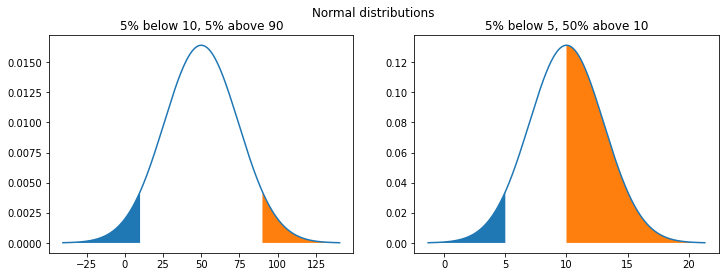

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

dist = norm_from_percentiles(10, 0.05, 90, 0.95)
show_pdf(ax1, dist)
show_percentiles(ax1, dist, 0.05, 0.95)
ax1.set(title="5% below 10, 5% above 90")


dist = norm_from_percentiles(5, 0.05, 10, 0.50)
show_pdf(ax2, dist)
show_percentiles(ax2, dist, 0.05, 0.50)
ax2.set(title="5% below 5, 50% above 10")
plt.suptitle("Normal distributions");

## Log-Normal Distribution

The paper stipulates that for a log-normal distribution, you can simply replace $$x_1$$ and $$x_2$$ with $$\log x_1$$ and $$\log x_2$$:

$$
\begin{align}
\textrm{scale} &= \frac{\log x_2 - \log x_1}{\phi^{-1}(p_2) - \phi^{-1}(p_1)} \\ \\
\textrm{location} &= \frac{(\log x_1)\phi^{-1}(p_2) - (\log x_2)\phi^{-1}(p_1)}{\phi^{-1}(p_2) - \phi^{-1}(p_1)}
\end{align}
$$

and as we shall see, that seems to work! However, following Scipy's [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) on `lognorm`, we also need to make a final transformation from this parametrization to SciPy's `shape` and `scale`. 

> A common parametrization for a lognormal random variable `Y` is in terms of the `mean`, `mu`, and standard deviation, `sigma`, of the unique normally distributed random variable `X` such that `exp(X) = Y`. This parametrization corresponds to setting `s = sigma` and `scale = exp(mu)`.

Here's the Python code:

In [9]:
def lognorm_from_percentiles(x1, p1, x2, p2):
    """ Return a log-normal distribuion X parametrized by:
    
            P(X < p1) = x1
            P(X < p2) = x2
    """
    x1 = np.log(x1)
    x2 = np.log(x2)
    p1ppf = norm.ppf(p1)
    p2ppf = norm.ppf(p2)
    
    scale = (x2 - x1) / (p2ppf - p1ppf)
    mean = ((x1 * p2ppf) - (x2 * p1ppf)) / (p2ppf - p1ppf)
    
    return lognorm(s=scale, scale=np.exp(mean))

The examples below use the same parameters as the normal distributions above, but look very different (they have a heavy right-skew). This highlights the importance of choosing the correct distribution.

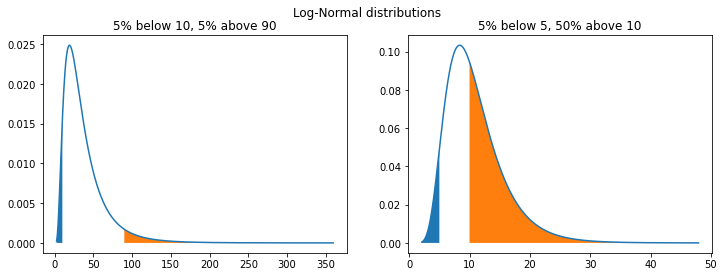

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

dist = lognorm_from_percentiles(10, 0.05, 90, 0.95)
show_pdf(ax1, dist)
show_percentiles(ax1, dist, 0.05, 0.95)
ax1.set(title="5% below 10, 5% above 90")


dist = lognorm_from_percentiles(5, 0.05, 10, 0.50)
show_pdf(ax2, dist)
show_percentiles(ax2, dist, 0.05, 0.50)
ax2.set(title="5% below 5, 50% above 10")
plt.suptitle("Log-Normal distributions");

## In conclusion

Sometimes, the best you have is your best guess, and it's much easier for people to guess things like "10% of people would pay less than X" than it is for people to directly guess the location and scale parameters of a distribution.


All of this has left me wondering: why isn't percentile parametrization more commonly found in maths packages and statistics libraries? I suppose it's just not a core functionality, and as we've seen it's pretty easy to implement if you need, but I feel like wider adoption of percentile parametrization could go a long way to making simple statistical modeling more accessible.

One great exception is [Guesstimate](https://www.getguesstimate.com/) (of the Flower Shop example from earlier), a great tool which allows users to define and combine a wide variety of distributions using percentiles. That being said, you're limited to 90% confidence intervals and in Guesstimate, whereas here we've demonstrated that you can use any percentiles you like.

Ultiamtely, this all just scratches the surface of a very interesting topic. For example, [Quantile Parametrized-Distributions](http://www.metalogdistributions.com/images/KeelinPowley_QuantileParameterizedDistributions_2011.pdf) are parametrized with 1st, 10th, 50th and 90th percentiles. Unlike the normal and log-normal distributions which are forever symmetric and right-skewed, the 5 parameters of QPDs produce an appropriately skewed distribution. An implementation in Javascript which generalizes these ideas even further can be found [here](https://observablehq.com/@whilp/gqpd).

The math is clearly out there, some people are clearly taking interest in this, and now this implimentation is out there too. Next time you need to model something using estimates, consider using percentiles!